In [1]:
# General
import os
import re
import sklearn
import nltk
import numpy as np
import pandas as pd
import contractions
import pickle
# Preprocessing
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
# models
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
import fastcluster
from scipy.cluster.hierarchy import dendrogram, cophenet
from scipy.spatial.distance import pdist
# Plots
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn
import seaborn as sns
# Enable inline plotting  
%matplotlib inline

# DATA India

In [2]:
# f = open('pipedata-simon/electricity_India/clean_texts.pkl', 'rb')   
# data1 = pd.DataFrame(pickle.load(f),columns=None) 

In [3]:
# f = open('pipedata-simon/prices_India/clean_texts.pkl', 'rb')   
# data2 = pd.DataFrame(pickle.load(f)) 

In [4]:
# f = open('pipedata-simon/renewable_India/clean_texts.pkl', 'rb')   
# data3 = pd.DataFrame(pickle.load(f)) 

# DATA Nigeria 

In [5]:
f = open('pipedata-simon/electricity_Nigeria/clean_texts.pkl', 'rb')   
data1 = pd.DataFrame(pickle.load(f),columns=None) 

In [6]:
f = open('pipedata-simon/prices_Nigeria/clean_texts.pkl', 'rb')   
data2 = pd.DataFrame(pickle.load(f)) 

In [7]:
f = open('pipedata-simon/renewable_Nigeria/clean_texts.pkl', 'rb')   
data3 = pd.DataFrame(pickle.load(f)) 

# DATA UK

In [8]:
# f = open('pipedata-simon/electricity_UK/clean_texts.pkl', 'rb')   
# data1 = pd.DataFrame(pickle.load(f),columns=None) 

In [9]:
# f = open('pipedata-simon/prices_UK/clean_texts.pkl', 'rb')   
# data2 = pd.DataFrame(pickle.load(f)) 

In [10]:
# f = open('pipedata-simon/renewable_UK/clean_texts.pkl', 'rb')   
# data3 = pd.DataFrame(pickle.load(f)) 

# DATA USA

In [11]:
# f = open('pipedata-simon/electricity_USA/clean_texts.pkl', 'rb')   
# data1 = pd.DataFrame(pickle.load(f),columns=None) 

In [12]:
# f = open('pipedata-simon/prices_USA/clean_texts.pkl', 'rb')   
# data2 = pd.DataFrame(pickle.load(f)) 

In [13]:
# f = open('pipedata-simon/renewable_USA/clean_texts.pkl', 'rb')   
# data3 = pd.DataFrame(pickle.load(f)) 

# Preprocessing

In [14]:
data = pd.concat([data1,data2,data3],axis=0)
# data = data1
data = shuffle(data)
data.index = range(len(data))

In [15]:
data.head()

,0
0,we are still having problems with our electric...
1,Perhaps because of renewable integrity Mad people
2,Dates change Nilotes don t Same vibes just a d...
3,on prescriptions won t moan at our prices again
4,For Rwanda its turning Offshore methane Gas in...


## Preprocess

In [16]:
corpus = data[0]
corpus = corpus.drop_duplicates() 

In [17]:
corpus = corpus.dropna()

In [18]:
len(corpus)

1050

In [19]:
from yellowbrick.text import PosTagVisualizer
viz = PosTagVisualizer(parser='nltk')

/Users/mahzadkhoshlessan/miniconda3/envs/omdena/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


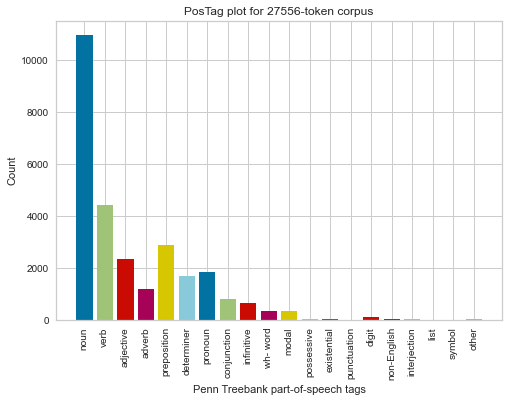

In [20]:
viz.fit(corpus)
viz.show()

## Feature Extraction

In [21]:
def featureextraction(corpus):
    
    vectorizer = TfidfVectorizer(max_df=.5,min_df=1,max_features=None,ngram_range=(1, 2),norm=None,binary=True,
                             use_idf=False,sublinear_tf=False,strip_accents = 'unicode',stop_words = 'english')
    vectorizer = vectorizer.fit(corpus)
    tfidf = vectorizer.transform(corpus)
    vocab = vectorizer.get_feature_names()

    return tfidf, vocab

In [22]:
tfidf, vocab = featureextraction(corpus)

## Agglomerative Hierarchical Clustering

__Pros__:
1) No assumption of a particular number of clusters (i.e. k-means)<br>
2) May correspond to meaningful taxonomies<br>
__Cons__:
1) Too slow for large data sets, O(𝑛2 log(𝑛))

The version of hierarchical clustering we will explore is called agglomerative clustering. Although Scikit-Learn has a library for this, it performs very slowly. Instead, we will choose to use another version of hierarchical clustering called fastcluster. This package is a C++ library with an interface in Python/SciPy.<br>
For more information, look here:<br>
http://danifold.net/fastcluster.html?section=1

User Manual:<br>
https://cran.r-project.org/web/packages/fastcluster/vignettes/fastcluster.pdf

In [23]:
len(vocab)

17379

In [24]:
np.shape(tfidf)

(1050, 17379)

In [25]:
pca = PCA(n_components=50).fit_transform(tfidf.todense())

In [26]:
Z = fastcluster.linkage_vector(pca,method='ward', metric='euclidean')

In [27]:
Z_dataFrame = pd.DataFrame(data=Z, 
    columns=['clusterOne','clusterTwo','distance','newClusterSize']) 

In [28]:
Z

array([[1.28000000e+02, 6.61000000e+02, 0.00000000e+00, 2.00000000e+00],
       [1.71000000e+02, 3.85000000e+02, 0.00000000e+00, 2.00000000e+00],
       [9.30000000e+01, 2.67000000e+02, 0.00000000e+00, 2.00000000e+00],
       ...,
       [2.09000000e+03, 2.09300000e+03, 1.57923251e+01, 3.25000000e+02],
       [2.09200000e+03, 2.09500000e+03, 2.89013160e+01, 7.25000000e+02],
       [2.09600000e+03, 2.09700000e+03, 3.55129118e+01, 1.05000000e+03]])

### Dendrograms 

We can use a dendrogram to visualize the history of groupings and figure out the optimal number of clusters. <br>
1) Determine the largest vertical distance that doesn’t intersect any of the other clusters<br>
2) Draw a horizontal line at both extremities<br>
3) The optimal number of clusters is equal to the number of vertical lines going through the horizontal line

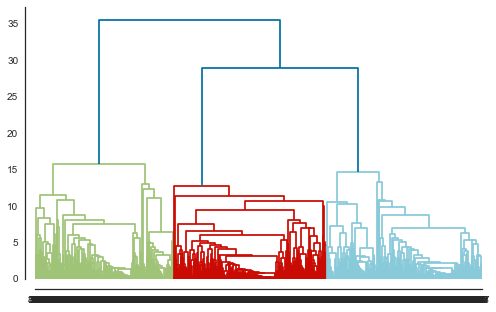

In [38]:
fig, ax = plt.subplots(figsize=(8,5))
dend = dendrogram(Z,leaf_rotation=45)
sns.set_style('white')
sns.despine(offset=10)
fig.savefig('{}.png'.format('dend'), bbox_inches='tight')

Following the above procedures and the Dendogram above the optimum number of clusters is __three__.

In [39]:
from scipy.cluster.hierarchy import fcluster

distance_threshold = 20
clusters = fcluster(Z, distance_threshold, criterion='distance')

In [40]:
len(clusters)

1050

In [41]:
from collections import Counter

In [42]:
count = Counter(clusters)

In [43]:
count

Counter({2: 361, 1: 325, 3: 364})

In [44]:
cluc = [k for k,x in count.items() if x>10]

In [45]:
cluc

[2, 1, 3]

In [46]:
from gensim.models.word2vec import Word2Vec

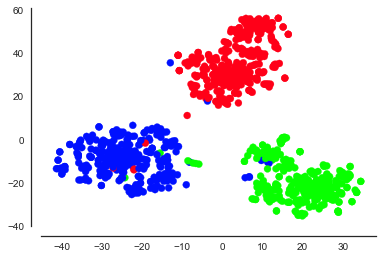

In [49]:
f, ax = plt.subplots(1, 1, figsize=(6, 4))
tsne = TSNE().fit_transform(pca)
max_label = max(clusters)
# label_subset1 = [cm.hsv(i/max_label) if i in cluc else 'white' for i in clusters]
# ax[0].scatter(tsne[:, 0], tsne[:, 1], c=label_subset1)
label_subset = [cm.hsv(i/max_label) for i in clusters]
ax.scatter(tsne[:, 0], tsne[:, 1], c=label_subset)
sns.despine(offset=10)
f.savefig('{}.png'.format('cluster'), bbox_inches='tight')

In [39]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
def get_top_keywords(data, clusters, labels, n_terms):
    df = pd.DataFrame(data.todense()).groupby(clusters).mean()
    df.columns = labels

    for i,r in df.iterrows():
        label_new = list(df.columns[np.argsort(df.iloc[i-1])])
        dd = pd.DataFrame([np.argsort(df.iloc[i-1])],columns=label_new)
        wordcloud = WordCloud(background_color = 'white')
        wordCloud = wordcloud.generate_from_frequencies(dd.iloc[0,-200:])
        plt.figure(figsize=(8, 8))
        plt.imshow(wordCloud)
        plt.axis("off")
        
        print('\nCluster {}'.format(i))
        print(','.join([labels[t] for t in np.argsort(r)[-n_terms:]]))


Cluster 1
kenya,world,technology,renewableenergy,africa,climate,sector,sustainable,clean,change,energy _url,today,training,electricity,nigeria,power,solar,renewable energy,energy,renewable

Cluster 2
access,day,know,state,like,solar,electricity _url,energy,light,use,people,pay,supply,hours,don,just,water,nigeria,power,electricity

Cluster 3
kindly,new,people,whatsapp,nigeria,best,don,like,today,delivery,just,sell,quality,prices _url,order,dm,available,affordable prices,affordable,prices


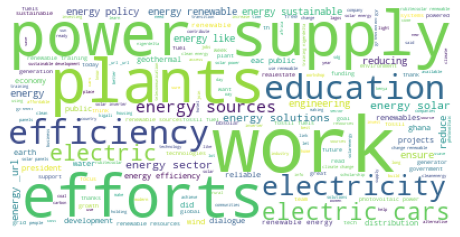

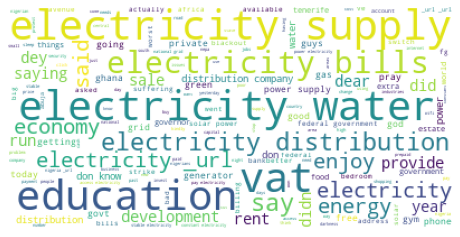

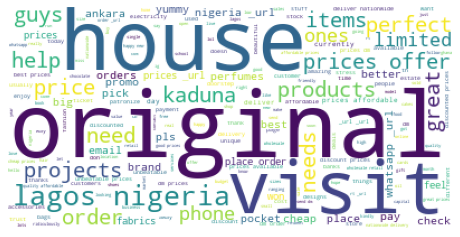

In [41]:
get_top_keywords(tfidf, clusters, vocab, 20)

# ScatterText

In [42]:
import spacy
nlp = spacy.load('en')

In [43]:
import scattertext as st
from IPython.core.display import display, HTML
from IPython.display import IFrame
# display(HTML("<style>.container { width:98% !important; }</style>"))

In [44]:
len(clusters)

1050

In [45]:
len(corpus)

1050

In [46]:
data11 = pd.DataFrame(corpus)
data11['clusters'] = clusters
data11.columns = ['text','clusters']

In [47]:
data11['parsed'] = data11.text.apply(nlp)

In [48]:
data11['clusters'] = data11['clusters'].astype(str)

In [49]:
data11.head()

,text,clusters,parsed
0,Electricity situation in Nigeria is terrible J...,2,"(Electricity, situation, in, Nigeria, is, terr..."
1,I am not insinuating anything However these th...,2,"(I, am, not, insinuating, anything, However, t..."
2,The effects of Climate Change are ernomous and...,1,"(The, effects, of, Climate, Change, are, ernom..."
3,Dino is not giving her any money it was a fake...,3,"(Dino, is, not, giving, her, any, money, it, w..."
4,I charge very good prices _URL,3,"(I, charge, very, good, prices, _, URL)"


In [50]:
corp = st.CorpusFromParsedDocuments(data11, category_col='clusters', parsed_col='parsed').build()

In [51]:
from scattertext import SampleCorpora, PhraseMachinePhrases, dense_rank, RankDifference, AssociationCompactor, produce_scattertext_explorer

In [52]:
import webbrowser

In [53]:
# file_name = 'ScattertextLog.html'
# Html_file= open(file_name,"wb")
# Html_file.write(html.encode('utf-8'))
# Html_file.close()

# webbrowser._tryorder
# browser = webbrowser.get(webbrowser._tryorder[1])
# browser.open(file_name)

In [54]:
corp1 = (st.CorpusFromParsedDocuments(data11, category_col='clusters', 
                            parsed_col='parsed').build().get_stoplisted_unigram_corpus())

In [56]:
target_term = 'affordability'
html = st.word_similarity_explorer(corp1,
                                   category='1',
                                   category_name='1',
                                   not_category_name='2',
                                   target_term=target_term,
                                   minimum_term_frequency=5,
                                   width_in_pixels=800)
file_name = 'word_similarity_affordability_Nigeria.html'
open(file_name, 'wb').write(html.encode('utf-8'))
# IFrame(src=file_name, width = 1200, height=700)

/Users/mahzadkhoshlessan/miniconda3/envs/omdena/lib/python3.8/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use context-sensitive tensors. You can always add your own word vectors, or use one of the larger models instead if available.
  return _run_code(code, main_globals, None,
/Users/mahzadkhoshlessan/miniconda3/envs/omdena/lib/python3.8/runpy.py:193: ModelsWarning: [W007] The model you're using has no word vectors loaded, so the result of the Doc.similarity method will be based on the tagger, parser and NER, which may not give useful similarity judgements. This may happen if you're using one of the small models, e.g. `en_core_web_sm`, which don't ship with word vectors and only use cont

655121

In [ ]:
html = st.produce_scattertext_explorer(corp1,
                                    category='1',
                                    category_name='1',
                                    not_categories=['2'],
                                    width_in_pixels=1000,
                                    minimum_term_frequency=5,
                                    sort_by_dist=True,
                                    transform=dense_rank,
                                    term_scorer=RankDifference())
file_name = 'ScattertextRankData12_Nigeria.html'
open(file_name, 'wb').write(html.encode('utf-8'))
# IFrame(src=file_name, width = 1200, height=700)

In [ ]:
html = st.produce_scattertext_explorer(corp1,
                                    category='1',
                                    category_name='1',
                                    not_categories=['3'],
                                    width_in_pixels=1000,
                                    minimum_term_frequency=5,
                                    sort_by_dist=True,
                                    transform=dense_rank,
                                    term_scorer=RankDifference())
file_name = 'ScattertextRankData13_Nigeria.html'
open(file_name, 'wb').write(html.encode('utf-8'))
# IFrame(src=file_name, width = 1200, height=700)